In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import time
from numba import jit

In [25]:
# A nice online resource is http://mattbierbaum.github.io/ising.js/ which has a good/fast 2d Ising simulation
# with code here https://github.com/mattbierbaum/ising.js

# You can also find a nicely optimized python version here: http://matthewrocklin.com/blog/work/2015/02/28/Ising
#@jit
def createAlignedState(N):
    """
    Returns a state in which every spin is pointing up as an N by N numpy array
    """
    return np.ones([N,N])
#@jit
def createJArray(state):
    J = np.random.uniform(size = [state.size, state.size])
    J += J.T
    return J
#@jit
def indexToCoord(index, state):
    return np.unravel_index(index, state.shape)
#@jit
def coordToIndex(spin, state):
    return np.ravel_multi_index(spin, state.shape)

def createRandState(N):
    """
    Returns a state in which every spin is randomized as an N by N numpy array
    """
    return np.random.choice([-1, 1], size = [N,N])

def calcTotalEnergy(state, J, mu, B):
    """
    Calculates the total energy in the presence of an external field B with the equation
    E = -J (Sum_neighbors s_i*s_j) - mu * B * (Sum s_i)
    
    args:
        state: a 2d numpy array of +1 or -1
        J: The self coupling term                    array type
        mu: The magnetic moment                      float
        B: The external, applied field               float
    returns:
        Energy: The energy of the state
    """
    (xSize, ySize) = state.shape
    JSize = state.size
    Energy = 0
    for x in range(xSize):
        for y in range(ySize):
            #print(x)
            #print(y)
            # Compute the interaction term with the 2 neighbors that are +1 in each direction
            Energy += -J[indexToCoord(coordToIndex(((x + 1) % xSize ,y), state), J)] * state[x,y] * state[(x+1) % xSize,y]
            #print(indexToCoord(coordToIndex(((x+1) % xSize,y), state) % JSize, J))
            Energy += -J[indexToCoord((coordToIndex((x,(y + 1) % ySize), state) + ySize), J)] * state[x,y] * state[x,(y+1) % ySize]  
            # Compute the interaction term with the field
            Energy += -mu*B*state[x,y]
            #print(Energy)
    return Energy
#@jit
def pickRandSite(state):
    """
    Returns a randomly chosen site within the state
    """
    (xSize, ySize) = state.shape
    return (np.random.randint(xSize), np.random.randint(ySize))
#@jit
def calcDeltaE(state, site, J, mu, B):
    """
    Returns the change in energy due to flipping the spin at the given site
    
    args:
        state: a 2d numpy array of +1 or -1
        site: the chosen site
    returns:
        deltaE: The change in energy
    """    
    (xSize, ySize) = state.shape
    JSize = state.size
    #print((site[0]+1, site[1]-1))
    deltaEField = 2 * mu * B * state[site] 
    deltaENeighbors = 2 * state[site]*(
              state[(site[0]-1) % xSize, site[1]] * J[indexToCoord(coordToIndex(((site[0]-1)%xSize,site[1]), state), J)]
            + state[(site[0]+1) % xSize, site[1]] * J[indexToCoord(coordToIndex(((site[0]+1)%xSize,site[1]), state), J)]
            + state[site[0], (site[1]-1) % ySize] * J[indexToCoord((coordToIndex((site[0],(site[1]-1)%ySize), state) - ySize) % JSize, J)]
            + state[site[0], (site[1]+1) % ySize] * J[indexToCoord((coordToIndex((site[0],(site[1]+1)%ySize), state) + ySize) % JSize, J)]
        )
    return deltaENeighbors + deltaEField
#@jit   
def ising2D(state, T, nFrames, J, mu=1, B=.1):
    """
    Runs the ising simulation for a specified number of frames, where a
    frame is the number of steps needed to interrogate every site once, on
    average.  Thus a frame is state.size steps
    
    args:
        state: a 2d numpy array of +1 or -1
        T: The temperature, given in energy units
        nFrames: The number of frames to run for
        B: The strength of the B-field
    """    
    nSteps = nFrames*state.size
    # Keep track of the total energy and magnetization of the system
    E = [calcTotalEnergy(state, J, mu, B)]
    M = [np.sum(state)]
       
    for t in range(1,nSteps):
        proposedSite = pickRandSite(state)
        deltaE = calcDeltaE(state, proposedSite, J, mu, B)
        # print(proposedSite, deltaE)
        #Accept the state if it lowers the energy or with probability e^(-deltaE/T)
        if ( deltaE <= 0 ) or ( np.random.rand() < np.exp(-deltaE/T) ):
            state[proposedSite] *= -1;
            E.append(E[-1] + deltaE)
            M.append(M[-1] + 2*state[proposedSite])
        else:
            E.append(E[-1])
            M.append(M[-1])
    
    R = correlationFunc(state)
    
    return state, np.array(E), np.array(M), R

def arrayRoll(state, r, axis_num):
    return np.roll(state, r, axis = axis_num)

def correlationFunc(state):
    global nSide
    """
    c(r) = (s_i*s_j).average - (s_i).average**2
    
    """
    s_i_j = []
    s_i = []
    for r in range(1, int(nSide/2)+1):
        for f in range(1, int(nSide/2)+1):
            s_i.append(state[r, f])
            vertical_roll = arrayRoll(state, r, 0)
            horizontal_roll = arrayRoll(state, f, 1)
            s_i_j.append(state[1,0] * horizontal_roll)
        s_i_j.append(state[0,0] * vertical_roll)
    R = (np.mean(s_i_j) - np.mean(s_i)**2)
            
    return R

Temperature 1.0 took 14.391309261322021 seconds to run 1000 frames
Temperature 1.1 took 14.934265613555908 seconds to run 1000 frames
Temperature 1.2000000000000002 took 14.810161590576172 seconds to run 1000 frames
Temperature 1.3000000000000003 took 14.934752225875854 seconds to run 1000 frames
Temperature 1.4000000000000004 took 15.644565343856812 seconds to run 1000 frames
Temperature 1.5000000000000004 took 14.494062423706055 seconds to run 1000 frames
Temperature 1.6000000000000005 took 14.624613285064697 seconds to run 1000 frames
Temperature 1.7000000000000006 took 15.295609712600708 seconds to run 1000 frames
Temperature 1.8000000000000007 took 14.334476947784424 seconds to run 1000 frames
Temperature 1.9000000000000008 took 16.01649022102356 seconds to run 1000 frames
Temperature 2.000000000000001 took 14.76821517944336 seconds to run 1000 frames
Temperature 2.100000000000001 took 15.179967164993286 seconds to run 1000 frames
Temperature 2.200000000000001 took 14.491045951843

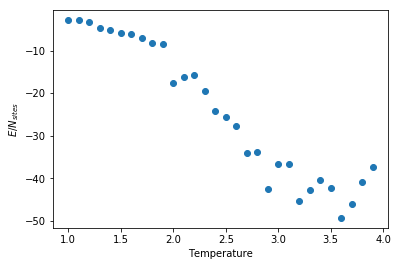

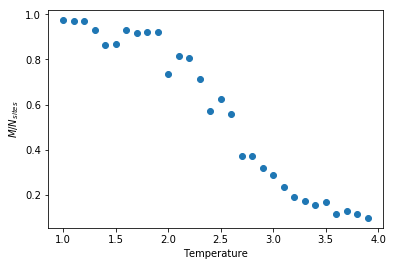

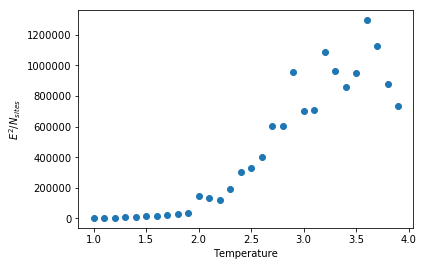

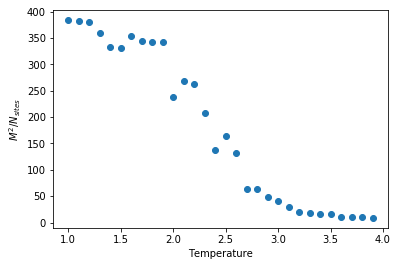

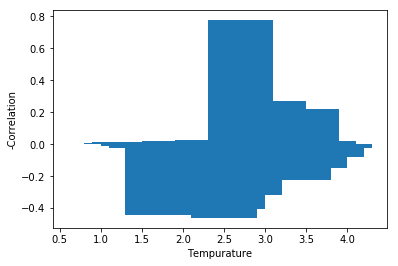

In [40]:
nFrames=1000
temperature = np.arange(1, 4, .1)
meanE=[]
meanM=[]
meanESq=[]
meanMSq=[]
Corr_R=[]
for T in temperature:
    start = time.time()
    nSide = 20
    state = createRandState(nSide)
    finalState, ETemp, MTemp, R = ising2D(state, T, nFrames, createJArray(state))
    meanE.append(np.mean(ETemp))
    meanM.append(np.mean(MTemp))
    meanESq.append(np.mean(ETemp**2))
    meanMSq.append(np.mean(MTemp**2))
    Corr_R.append(R)
    end = time.time()
    print(f'Temperature {T} took {end-start} seconds to run {nFrames} frames')

plt.figure(0)
plt.plot(temperature, np.array(meanE)/(nSide*nSide),'o')
plt.xlabel('Temperature')
plt.ylabel('$E/N_{sites}$')

plt.figure(1)
plt.plot(temperature, np.array(meanM)/(nSide*nSide),'o')
plt.xlabel('Temperature')
plt.ylabel('$M/N_{sites}$')

plt.figure(2)
plt.plot(temperature, np.array(meanESq)/(nSide*nSide),'o')
plt.xlabel('Temperature')
plt.ylabel('$E^2/N_{sites}$')

plt.figure(3)
plt.plot(temperature, np.array(meanMSq)/(nSide*nSide),'o')
plt.xlabel('Temperature')
plt.ylabel('$M^2/N_{sites}$')

plt.figure(4)
plt.bar(temperature, -np.array(Corr_R))
plt.xlabel('Tempurature')
plt.ylabel('-Correlation')

ValueError: bins must increase monotonically.

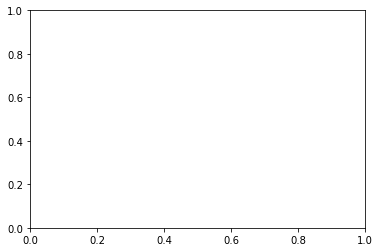

In [49]:
plt.hist(temperature, np.array(Corr_R))
print(temperature)